In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import os, sys
os.chdir("..")
from Source.Models.autoregGMM import AutoRegGMM
import Source.Util.preprocessing as prep
from Source.Util.util import load_params, get, get_device
from Source.Util.simulateToyData import ToySimulator
import scipy.integrate as itg
import torch.distributions as D
import torch
from torch.utils.data import DataLoader
import scipy.stats as stats

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
font_dir = ['paper/bitstream-charter-ttf/Charter/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
mpl.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Charter"
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage[bitstream-charter]{mathdesign} \usepackage{amsmath}'

In [3]:
xmin, xmax = -1.5, 1.5

In [4]:
def pjoint(x1, x0, mu=1., sigma=.1):
    return 1/(2*np.pi * (2*np.pi*sigma**2)**.5) * np.exp(-( (x0**2+x1**2)**.5 - mu)**2 /(2*sigma**2))
def pmarg(x, mu=1., sigma=.1):
    if type(x) is np.ndarray:
        res = np.zeros_like(x)
        for i in range(len(x)):
            res[i], _ = itg.quad(lambda xOther: pjoint(x[i], xOther, mu=mu, sigma=sigma), -np.inf, np.inf)
    else:
        res, _ = itg.quad(lambda xOther: pjoint(x, xOther, mu=mu, sigma=sigma), -np.inf, np.inf)
    return res
def pcond(x1, x0, mu=1., sigma=.1):
    return pjoint(x1, x0, mu=mu, sigma=sigma) / pmarg(x0)
test, _ = itg.quad(pmarg, -np.inf, np.inf)
print(test)

0.9999999999999548


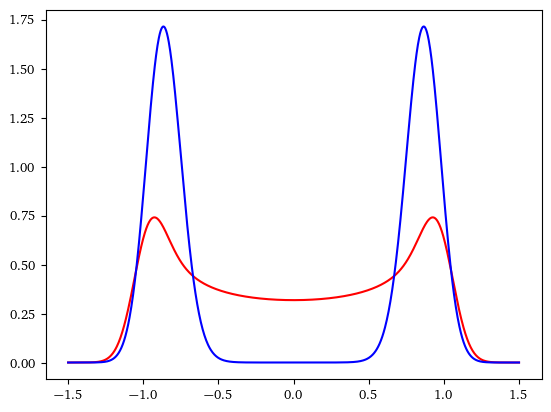

In [5]:
prec = 1000
x = np.linspace(xmin, xmax, prec)
pmargx = pmarg(x)
pcondx = pcond(x, .5)
plt.plot(x, pmargx, color="r")
plt.plot(x, pcondx, color="b")
plt.show()

# Test other versions

In [6]:
def pjoint2(x1, x0, mu=1., sigma=.1):
    return 1/(2*np.pi*sigma**2)**.5 * np.exp(-( (x0**2+x1**2)**.5 - mu)**2 /(2*sigma**2)) /(x0**2 + x1**2)**.5 / (2*np.pi)
def pmarg2(x, mu=1., sigma=.1):
    if type(x) is np.ndarray:
        res = np.zeros_like(x)
        for i in range(len(x)):
            res[i], _ = itg.quad(lambda xOther: pjoint2(x[i], xOther, mu=mu, sigma=sigma), -np.inf, np.inf)
    else:
        res, _ = itg.quad(lambda xOther: pjoint2(x, xOther, mu=mu, sigma=sigma), -np.inf, np.inf)
    return res
def pcond2(x1, x0, mu=1., sigma=.1):
    return pjoint2(x1, x0, mu=mu, sigma=sigma) / pmarg(x0)
test, _ = itg.quad(pmarg2, -np.inf, np.inf)
print(test)

0.9999999999999699


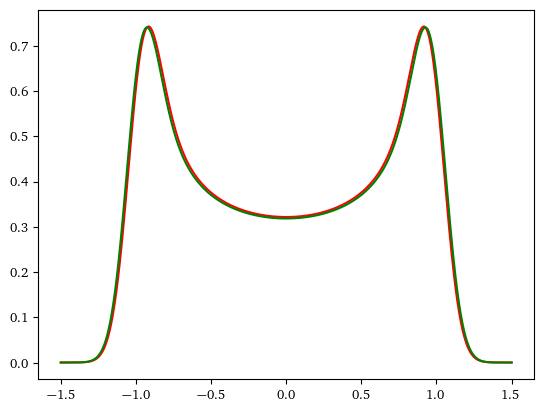

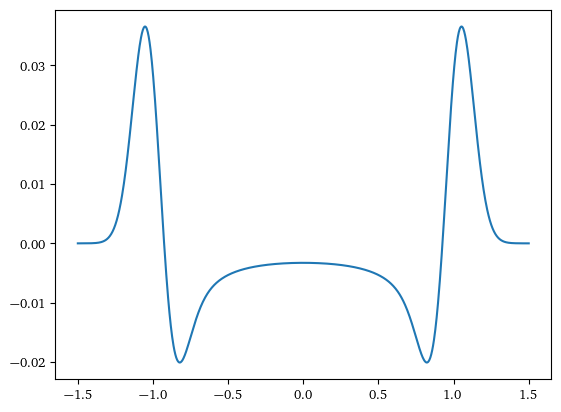

In [7]:
prec = 1000
x = np.linspace(-1.5, 1.5, prec)
pmargx2 = pmarg2(x, mu=1., sigma=.1)
pcondx2 = pcond2(x, .5, mu=1., sigma=.1)
plt.plot(x, pmargx2, color="r")
#plt.plot(x, pcondx2, color="b")

pmargx = pmarg(x, mu=1., sigma=.1)
pcondx = pcond(x, .5, mu=1., sigma=.1)
plt.plot(x, pmargx, color="g")
#plt.plot(x, pcondx, color="k")
plt.show()

plt.plot(x, pmargx - pmargx2)
plt.show()

# Load model and data

In [8]:
runpath = "runs/paper_GMM_sphere5_1/"
#runpath = "runs/AutoRegGMM_toy_8522/"

In [9]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
params["device"]=get_device()

In [10]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=16, n_blocks=4, intermediate_fac=4, n_gauss=21
Bayesianization hyperparameters: bayesian=4, prior_prec=1.0, iterations=30


<All keys matched successfully>

In [11]:
data = ToySimulator(params).data

# Conditional likelihoods plot

In [12]:
# Hand-craft samples
n_samples = 2
samples = np.zeros((n_samples, 2))
samples[0,0], samples[0,1] = 0., 1.,
samples[1,0], samples[1,1] = 1., 0.
print(samples)

[[0. 1.]
 [1. 0.]]


In [13]:
#TBD: Evaluate likelihoods for many phase-space points
prec = int(1e4)
x_test = np.linspace(xmin, xmax, prec)
def getLikelihood(x, x_test):
    device = get_device()
    x = torch.cat((torch.zeros(x.size(0), 1, device=device), x), dim=1) #add start-of-sequence token
    idx = x[:, :-1]
    targets = x[:, 1:]

    mu, sigma, weights = model.net(idx)    
    mix = D.Categorical(weights)
    comp = D.Normal(mu, sigma)
    gmm = D.MixtureSameFamily(mix, comp)
        
    logLikelihoods = torch.zeros(n_samples, 2, prec) #TBD
    for i in range(prec): #TBD
        logLikelihoods[:,:,i] = gmm.log_prob(x_test[i]) #TBD
    
    return torch.exp(logLikelihoods).detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy(), weights.detach().cpu().numpy()

In [34]:
probs, mu, sigma, weights = getLikelihood(torch.Tensor(samples), torch.Tensor(x_test))
print(np.shape(probs), np.shape(x_test))
print(mu.shape)

(2, 2, 1000) (1000,)
(2, 2, 21)


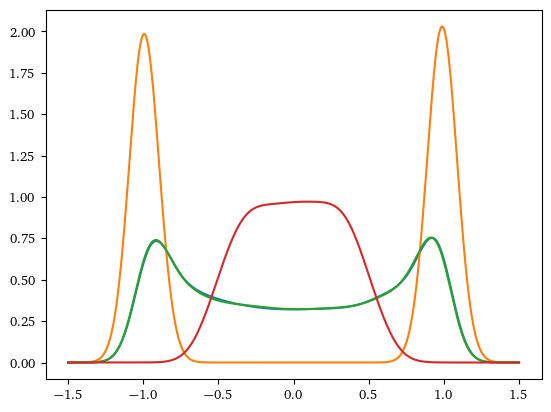

In [35]:
plt.plot(x_test, probs[0,0,:])
plt.plot(x_test, probs[0,1,:])
plt.plot(x_test, probs[1,0,:])
plt.plot(x_test, probs[1,1,:])
plt.show()

In [58]:
data2 = data
x_range = [-1.5, 1.5]
frect = (.08, .1, 1.03, 1.02)

def hist2d(filenameOut=None, prec=1000, bins=60, fSize=22, al=.2):
    color="#0343DE"
    f, ax = plt.subplots(1,1, figsize=(4,4))
    f.tight_layout(rect=frect)
    
    x_test=np.linspace(x_range[0], x_range[1], prec)
    probs = np.zeros((prec, prec))
    for i in range(prec):
        for j in range(prec):
            probs[i,j] = pjoint(x_test[i], x_test[j])
    ax.contourf(x_test, x_test, probs, cmap="Greys")
    
    ax.tick_params(axis="both", labelsize=fSize-1)
    ax.set_xlabel(r"$x_1$", fontsize=fSize)
    ax.set_ylabel(r"$x_2$", fontsize=fSize)
    ax.set_ylim(x_range)  
    ax.set_xlim(x_range)
    
    #ax.vlines(0, x_range[0], x_range[1], color="red")
    ax.text(0.4, 1.2, r"$p(x_1,x_2)$", fontsize=fSize)
        
    if(filenameOut!=None):
        f.savefig(filenameOut, format="pdf")
    
def probPlot1(probs, isample, filenameOut=None, ymax0=None, 
              var=None, n_bins = 60, fSize=22, al=.2):
    colors = ["black","#A52A2A", "#0343DE"]
    ndim = np.shape(probs)[1]
    
    f, ax = plt.subplots(1,1, figsize=(4,4))
    f.tight_layout(rect=frect)
    idim= 0
    ymax=np.zeros(ndim)
    ax.plot(x_test, pmarg(x_test), color=colors[2], 
                                    label="Truth")
    ax.plot(x_test, probs[isample,idim,:], color=colors[1], 
                                     label="AT")
    for igauss in range(mu.shape[2]):
        ax.plot(x_test, weights[isample,idim,igauss] * stats.norm.pdf(x_test, loc=mu[isample,idim,igauss], 
                                                                           scale=sigma[isample,idim,igauss]),
                    color=colors[1], alpha=al)
    
    
    ax.set_xlabel(r"$x_1$", fontsize=fSize)
    ax.set_ylabel(r"$p(x_1)$", fontsize=fSize)
    ax.legend(loc="upper center", frameon=False, fontsize=fSize)
    ax.set_ylim(0., ymax0)  
    ax.set_xlim(x_range)
    ax.tick_params(axis="both", labelsize=fSize-1)  
    ax.set_yticks([0,1])
        
    if(filenameOut!=None):
        f.savefig(filenameOut, format="pdf")
    #plt.close()
    
def probPlot2(probs, isample, filenameOut=None, ymax0=None, var=None, n_bins = 60, fSize=22, al=.2):
    colors = ["black","#A52A2A", "#0343DE"]
    ndim = np.shape(probs)[1]
    
    f, ax = plt.subplots(1,1, figsize=(4,4))
    f.tight_layout(rect=frect)
    
    ymax=np.zeros(ndim)
    idim = 1
    ax.plot(x_test, pcond(x_test, samples[isample, idim-1]), color=colors[2], 
                                     label="Truth")
    ax.plot(x_test, probs[isample,idim,:], color=colors[1], 
                label="AT")
    for igauss in range(mu.shape[2]):
        ax.plot(x_test, weights[isample,idim,igauss] * stats.norm.pdf(x_test, loc=mu[isample,idim,igauss], 
                                                                           scale=sigma[isample,idim,igauss]),
                    color=colors[1], alpha=al)

    ax.set_xlabel(r"$x_2$", fontsize=fSize)
    if isample==0:
        ax.set_ylabel(r"$p(x_2|x_1=0)$", fontsize=fSize)
        ax.legend(loc="upper center", frameon=False, fontsize=fSize)
        ax.set_yticks([0,1,2])
    else:
        ax.set_ylabel(r"$p(x_2|x_1=1)$", fontsize=fSize)
        ax.legend(loc="upper right", frameon=False, fontsize=fSize)
        ax.set_yticks([0,1])
    ax.set_ylim(0., ymax0)    
    ax.set_xlim(x_range)
    ax.tick_params(axis="both", labelsize=fSize-1)
        
    if(filenameOut!=None):
        f.savefig(filenameOut, format="pdf")
    #plt.close()

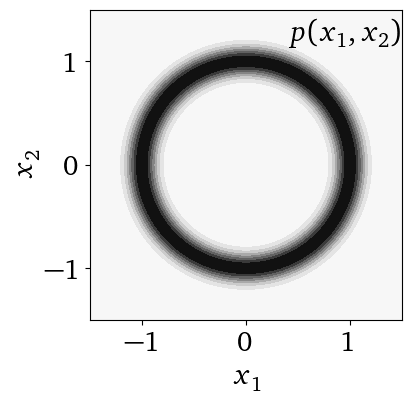

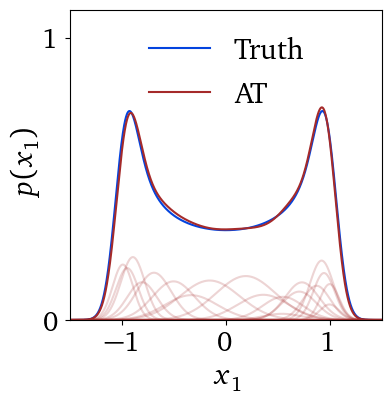

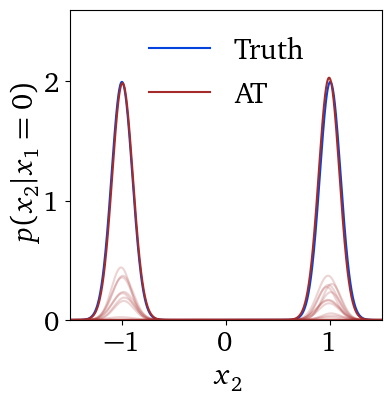

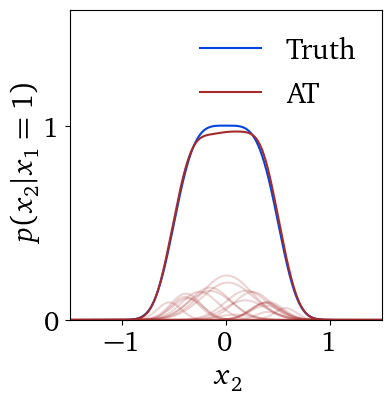

In [59]:
with PdfPages("Scripts/conditionalSphere.pdf") as pp:
    hist2d(filenameOut=pp)
    probPlot1(probs, 0, filenameOut=pp, ymax0=1.1)
    probPlot2(probs, 0, filenameOut=pp, ymax0=2.6)
    probPlot2(probs, 1, filenameOut=pp, ymax0=1.6)